In [375]:
import numpy as np
from scipy.interpolate import interp1d
import time
import redshifts
from math import lgamma
import loginterp
import common as c
import copy
import scipy
from scipy.linalg import cholesky
from scipy import linalg
import healpy as hp
import config as conf
import estim
from estim import estimator
import pyfftlog 
import importlib
import redshifts
import spectra
import matplotlib.pyplot as plt
from math import pi

In [309]:
def plot_cross_section(fft3dmap):
    fig, _ = plt.subplots(3, 1,figsize=(6*1,4.5*3))
    
    ax1 = plt.subplot(3,1,1)
    fig.colorbar(ax1.imshow(fft3dmap[0,:,:], origin='lower'), ax=ax1)
    ax1.set_xlabel('y')
    ax1.set_ylabel('z')

    ax2 = plt.subplot(3,1,2)
    # ax2.imshow(psi_i[0,:,:].T)
    fig.colorbar(ax2.imshow(fft3dmap[:,0,:].T, origin='lower'), ax=ax2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')

    ax3 = plt.subplot(3,1,3)
    # ax3.imshow(psi_i[:,10,:])
    fig.colorbar(ax3.imshow(fft3dmap[:,:,0], origin='lower'), ax=ax3)
    ax3.set_xlabel('y')
    ax3.set_ylabel('x')

In [168]:
importlib.reload(conf)
importlib.reload(estim)
zb = redshifts.binning(conf_module = conf) 
# test vmap simulation
data_lmax = 4000

nside = 30
lmax = 4000

estimator = estimator(data_lmax, conf)

Cls = estimator.load_theory_Cl('vr', 'vr')
print(Cls.shape)
print('Generating vmap and vlm')

maps, alms = estimator.get_maps_and_alms(['vr', 'taud', 'g'], nside, lmax)

Default lss = 'g' . Modify with set_lss method.
Default N_fine_modes = 10. Modify with set_Nfine method.
(95, 10, 10)
Generating vmap and vlm
cholesky
formatting covmat
generating realization


In [170]:
vmaps, taudmaps, lssmaps = maps[0], maps[1], maps[2]

[0.2        0.38702986 0.5972872  0.83836002 1.12027677 1.45656977
 1.8659345  2.37489138 3.02220103 3.86648352 5.        ]
[ 839.32081353 1545.77919441 2252.23757528 2958.69595616 3665.15433703
 4371.61271791 5078.07109878 5784.52947966 6490.98786053 7197.44624141
 7903.90462228]
706.4583808746094


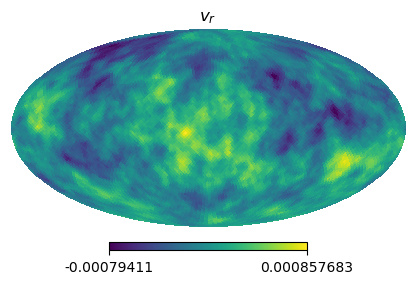

In [181]:
print(zb.zbins_z)
print(zb.zbins_chi)
print(zb.deltachi)
if 1:
    plt.figure(figsize=(4,3))
    hp.mollview(vmaps[0], sub=111, title=r'$v_{r}$')

In [182]:
# test spectra.fftlog_weights
if 0:
    b = 2
    chis = np.arange(3000, 3200, 1)
    chi_1 = zb.zbins_chi[b]
    chi_2 = zb.zbins_chi[b+1]
    print(chi_1)
    print(chi_2)
    FW = spectra.fftlog_weights('vr', None, b, chis)
    print(FW.shape)
    F = spectra.ffts_tracer('vr', None, b, 20)
    print(F.shape)

In [183]:
ell = 20
Cl = spectra.Cl('vr', 'vr', None, None, ell)
Cl.shape

(10, 10)

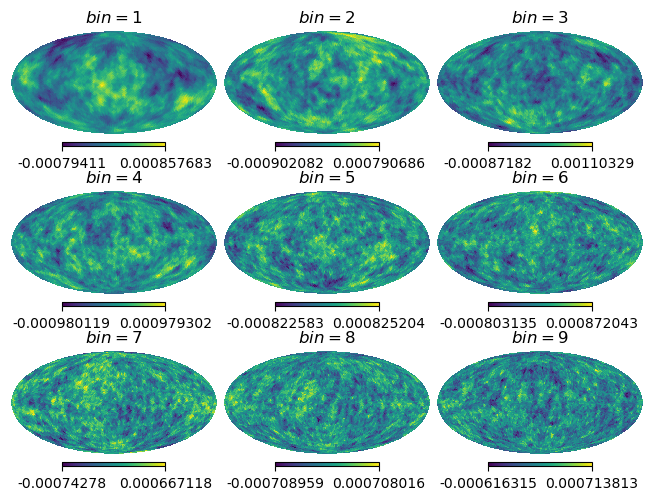

In [208]:
for bin_i in range(conf.N_bins-1):
    subnum = '33'+r'%s' %(bin_i+1)
    hp.mollview(vmaps[bin_i], sub=int(subnum), title=r'$bin=%s$' %(bin_i+1))

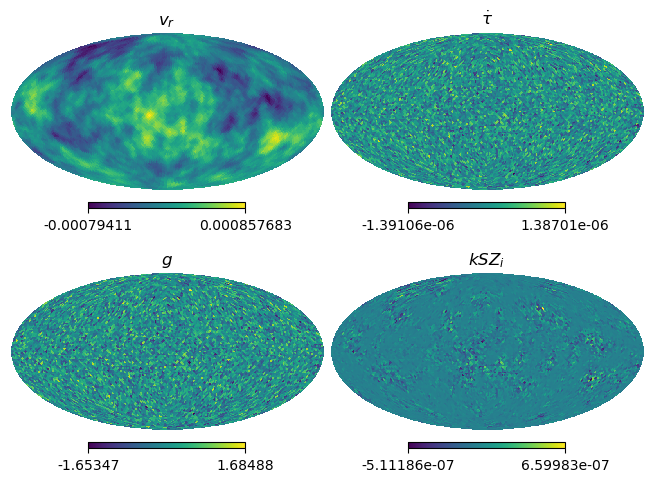

In [211]:
# test kSZ map making
bin_i = 0
kszmap = vmaps[bin_i]*taudmaps[bin_i]*deltachi
if 1:
    hp.mollview(vmaps[bin_i], sub=221, title=r'$v_{r}$') 
    hp.mollview(taudmaps[bin_i], sub=222, title=r'$\dot{\tau}$') 
    hp.mollview(lssmaps[bin_i], sub=223, title=r'$g$') 
    hp.mollview(kszmap, sub=224, title=r'$kSZ_{i}$') 
    

In [214]:
# starts to implement the vr sim from large-scale inhomogenieties
# exploit more on fft algorithm
import param

In [215]:
importlib.reload(param)
# speed of light
c = param.c
# Hubble parameter, kms^-1Mpc^-1
H0 = param.H0
# observable universe radius,14260 Mpc
r_o = param.r_o
# the boundary position of the two bubbles, Mpc
x_c = param.x_c
r_H = c/H0
# initial potential from bubble collision psi_i parametried by A and B, Eq.2.2
# A = 1.e-4 # 1-sigma limit
# B = 1.e-4 # 1-sigma limit

A = param.A
B = param.B
# need a resolution of the 3-d grid?
d = param.d
N = int(2*r_o/d) +1

print('A=%s, B=%s' %(A,B))
print('r_H=%s Mpc' %r_H)

A=0.0001, B=0.0
r_H=4411.764705882353 Mpc


In [218]:
# 3-d real space axes
x = np.arange(-r_o, r_o+d, d)
y = np.arange(-r_o, r_o+d, d)
z = np.arange(-r_o, r_o+d, d)
# 3-d meshgrid coordinate
# xx, yy = np.meshgrid(x, y)
xx, yy, zz = np.meshgrid(x, y, z)

In [219]:
# 3-d k-space axes
k_x = np.arange(-r_o/d, (r_o+d)/d)/(d*N)
k_y = np.arange(-r_o/d, (r_o+d)/d)/(d*N)
k_z = np.arange(-r_o/d, (r_o+d)/d)/(d*N)
# 3-d meshgrid k-space coordinate
k_xx, k_yy, k_zz = np.meshgrid(k_x, k_y, k_z)
# as a comparison with np.fft.fftfreq(21, 10)

In [228]:
kk = np.sqrt(k_xx**2 + k_yy**2 + k_zz**2)

Text(0.5, 0.92, '$k-space$')

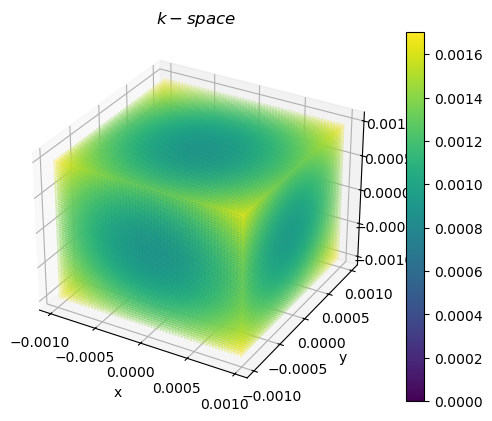

In [271]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.colorbar(ax.scatter(k_xx,k_yy,k_zz, c=abs(kk), s=0.1))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$k-space$')

In [237]:
# plot kk
if 0:
    fig, _ = plt.subplots(3, 1,figsize=(6*1,4.5*3))
    
    ax1 = plt.subplot(3,1,1)
    # ax1.imshow(psi_i[:,:,0])
    fig.colorbar(ax1.imshow(kk[0,:,:], origin='lower'), ax=ax1)
    ax1.set_xlabel('y')
    ax1.set_ylabel('z')

    ax2 = plt.subplot(3,1,2)
    # ax2.imshow(psi_i[0,:,:].T)
    fig.colorbar(ax2.imshow(kk[:,0,:].T, origin='lower'), ax=ax2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('z')

    ax3 = plt.subplot(3,1,3)
    # ax3.imshow(psi_i[:,10,:])
    fig.colorbar(ax3.imshow(kk[:,:,0], origin='lower'), ax=ax3)
    ax3.set_xlabel('y')
    ax3.set_ylabel('x')

In [307]:
# should cut kk meshgrid and only keep small ks, use np.where?
k_threshold = 0.001
kk_cut = np.where(kk<k_threshold, kk, 0*kk)

Text(0.5, 0.92, '$k-space, cut$')

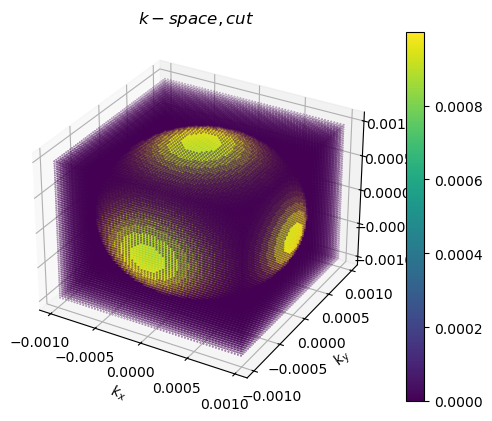

In [313]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.colorbar(ax.scatter(k_xx,k_yy,k_zz, c=abs(kk_cut), s=0.1))
ax.set_xlabel(r'$k_{x}$')
ax.set_ylabel(r'$k_{y}$')
ax.set_zlabel(r'$k_{z}$')
ax.set_title(r'$k-space, cut$')

In [311]:
# plot kk
if 0:
    plot_cross_section(kk_cut)

In [317]:
# 3-d real space axes
x = np.arange(-r_o, r_o+d, d)
y = np.arange(-r_o, r_o+d, d)
z = np.arange(-r_o, r_o+d, d)
# 3-d meshgrid coordinate
# xx, yy = np.meshgrid(x, y)
xx, yy, zz = np.meshgrid(x, y, z)

In [345]:
# distribute values to the initial potential from bubble collision, note that the part where x<xc is zero
x_xc = np.concatenate((np.zeros(int((r_o+x_c)/d)), np.arange(0, r_o-x_c+d, d)))
xx_xc, _, _ = np.meshgrid(x_xc, y, z)
psi_i = A*(xx_xc/r_H) + B*(xx_xc/r_H)**2
g_psi_i = np.gradient(psi_i)

Text(0.5, 0.92, '$input\\ \\psi_{i}$')

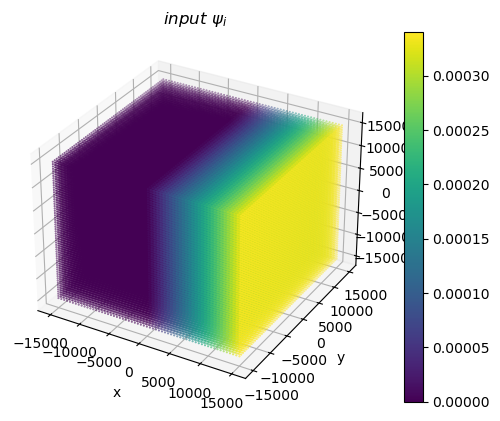

In [346]:
# visulizing 3-d potential
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.colorbar(ax.scatter(xx,yy,zz, c=psi_i, s=0.2))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$input\ \psi_{i}$')

In [347]:
rr = np.sqrt(xx**2 + yy**2 + zz**2)
# give value to the origin point where r=0
rr[np.where(rr==0)]=1

Text(0.5, 0.92, '$r$')

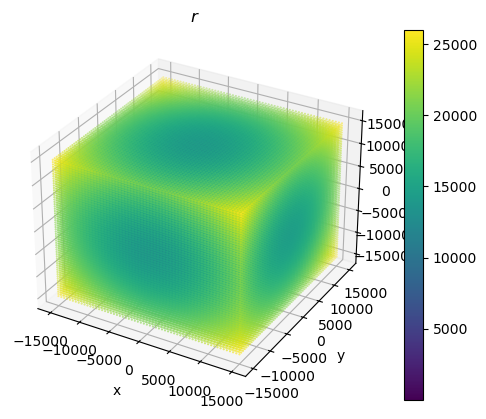

In [348]:
# plot rr
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.colorbar(ax.scatter(xx,yy,zz, c=rr, s=0.2))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$r$')

In [354]:
xx_unit, yy_unit, zz_unit = xx/rr, yy/rr, zz/rr

In [366]:
g_psi_i_radial = -(g_psi_i[0]*yy_unit + g_psi_i[1]*xx_unit + g_psi_i[2]*zz_unit)

Text(0.5, 0.92, '$(\\nabla \\psi_{i})_{r}$')

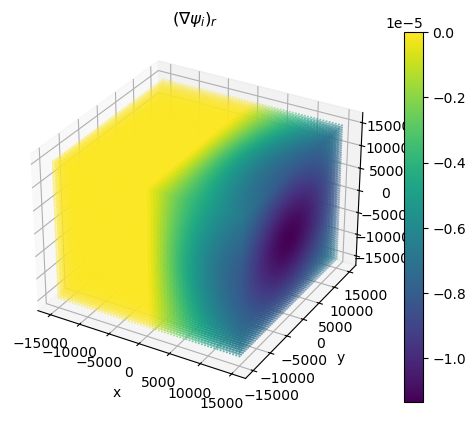

In [373]:
# plot rr
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.colorbar(ax.scatter(xx,yy,zz, c=g_psi_i_radial, s=0.2))
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')
ax.set_title(r'$(\nabla \psi_{i})_{r}$')
# ax.view_init(0, 0) 

Text(0.5, 0, 'z')

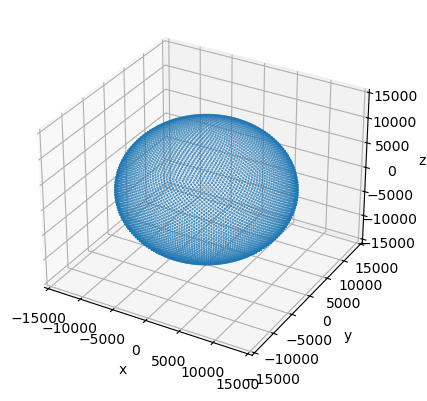

In [387]:
# try to plot the V_eff on a light cone sphere using healpix
NSIDE = nside
NPIX = hp.nside2npix(NSIDE)
r_dec = 12000

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

theta, phi = np.degrees(hp.pix2ang(nside=NSIDE, ipix=np.arange(NPIX)))
theta = theta * pi / 180.0
phi = phi * pi / 180.0

x_test_s = r_dec*np.sin(theta)*np.cos(phi)
y_test_s = r_dec*np.sin(theta)*np.sin(phi)
z_test_s = r_dec*np.cos(theta)

ax.scatter(x_test_s,y_test_s,z_test_s, s=0.2)
ax.set_xlim([-r_o, r_o])
ax.set_ylim([-r_o, r_o])
ax.set_zlim([-r_o, r_o])
ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')

In [389]:
from scipy.interpolate import RegularGridInterpolator
g_psi_i_radial_itp = RegularGridInterpolator((x, y, z), g_psi_i_radial)

In [395]:
# LC for light cone
g_psi_i_radial_LC = g_psi_i_radial_itp((y_test_s, x_test_s, z_test_s))

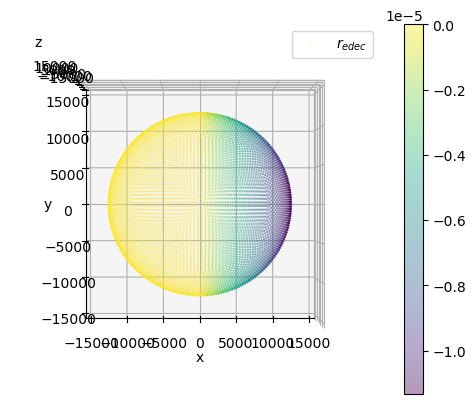

In [397]:
# check https://stackoverflow.com/questions/11140163/plotting-a-3d-cube-a-sphere-and-a-vector
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.colorbar(ax.scatter(x_test_s, y_test_s, z_test_s, c=g_psi_i_radial_LC, alpha=0.4, label=r'$r_{edec}$', s=0.2))

ax.set_xlabel(r'x')
ax.set_ylabel(r'y')
ax.set_zlabel(r'z')

# ax.plot_surface(xx_c, yy_c, zz_c, alpha=0.2)
ax.set_xlim([-r_o, r_o])
ax.set_ylim([-r_o, r_o])
ax.set_zlim([-r_o, r_o])
ax.legend()
# check xy direction view
ax.view_init(90, -90) 

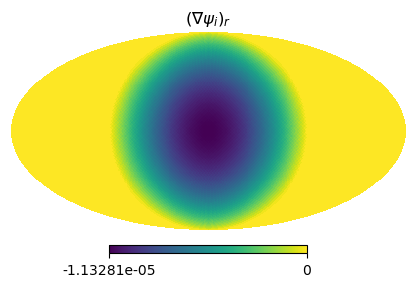

In [401]:
# show the SW effect on healpix 2d map
if 1:
    plt.figure(figsize=(4,3))
    hp.mollview(g_psi_i_radial_LC, xsize=800, sub=111, title=r'$(\nabla \psi_{i})_{r}$')